<a href="https://colab.research.google.com/github/ShadowKrius/cs403/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 5 Cart-pole Dynamics Simulation**

The goal of HW 5 is to create a dynamics simulation of a cart-pole system (1) by yourself, and (2) by using Mujoco simulator.

<img src="https://github.com/DARoSLab/CS403_2025_Fall/blob/main/Figures/cart-pole.png?raw=true" width="450">

Use a generalized coordinate given in the figure. We give forward kinematics of important places of the system.

\begin{align}
rA= \begin{pmatrix}
    x \\
    0 \\
    0
     \end{pmatrix},  &
\ rB = \begin{pmatrix}
    x + ccos(\theta)  \\
    csin(\theta) \\
    \theta
     \end{pmatrix}
\\[10pt]
\implies vA= \begin{pmatrix}
    \dot{x} \\
    0 \\
    0
     \end{pmatrix}, &
\ vB = \begin{pmatrix}
    \dot{x} -c\dot{\theta}sin(\theta)  \\
    c\dot{\theta}cos(\theta) \\
    \dot{\theta}
     \end{pmatrix}
\\[10pt]
\implies aA= \begin{pmatrix}
    \ddot{x} \\
    0 \\
    0
     \end{pmatrix}, &
\ aB = \begin{pmatrix}
    \ddot{x} -c\ddot{\theta}sin(\theta)-c\dot{\theta}^2cos(\theta)  \\
    c\ddot{\theta}cos(\theta) - c\dot{\theta}^2sin(\theta) \\
    \ddot{\theta}
     \end{pmatrix}
\\[10pt]
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# **Q.1 Dynamics of a cart-pole system**

To make a dynamics simulation, we first need to complete the formula:

$M \ddot{q} + b (q, \dot{q}) + g(q) = \begin{pmatrix} f \\ \tau \end{pmatrix} $.

As a first step, identify $M$ (Mass matrix), $b$ (Coriolis and Centripetal force), and $g$ (Gravitational force).

## Q.1.(a) [20 pts] Dynamics function
Based on the given template code, complete the function returning the acceleration of the generalized coordinate:

$\ddot{q} = \begin{pmatrix}
\ddot{x} \\ \ddot{\theta}
\end{pmatrix} = M^{-1}\left( u - b -g \right)$

In [2]:
def dynamics(q, u, params):
  m1, m2, I2, c, g = params
  x, th, xdot, thdot  = q.tolist()

  # Write your code here :
  # define b (coriolis and centripetal), g (gravitational force), and M (mass matrix)
  # Then compute acceleration (qddot)
  M = np.array([[m1 + m2, -m2*c*np.sin(th)], [-m2*c*np.sin(th), m2*c**2 + I2]])
  b = np.array([-m2*c*thdot**2*np.cos(th), 0])
  g_vec = np.array([0, m2*g*c*np.cos(th)])
  qddot = np.linalg.solve(M, u - b - g_vec)
  # .........................................
  return qddot

In [3]:
# Test function: No need to change
def test_dynamics():
  m1 = 0.5
  m2 = 0.5
  I2 = 1
  c = 0.2
  g = 9.81
  params = [m1, m2, I2, c, g]
  test_cases = np.array([[0.0, np.pi/4, 0.0, 0.0],
                [0.5, -np.pi/4, 0.0, 0.0],
                [0.0, 0, 0.5, 0.0],
                [0.0, 0, 0.0, 5],
                ])
  soln = np.array([[-0.04832512, -0.68342045],
                   [ 0.04832512, -0.68342045],
                   [ 0.,         -0.96176471],
                   [ 2.5,        -0.96176471]])
  u = np.array([0, 0])
  res = np.zeros((4, 2))
  for i, q in enumerate(test_cases):
    res[i, :] = dynamics(q, u, params)
  assert np.allclose(res, soln), f"your dynamics implementation is not correct: your result {res} != solution: \n {soln}"
  print('Your implementation is correct!!')
test_dynamics()

Your implementation is correct!!


## Q 1.(b) [15 pts] Dynamics simulation

Complete the following function that computes state trajectory based on the dynamics function we implemented in Q.1 (a).

In [4]:
def simulate_cartpole(x0, params, tf=1.0, dt=0.005):
  m1, m2, I2, c, g = params
  num_step = int(np.floor(tf/dt));
  tspan = np.linspace(0, tf, num_step);
  x_out = np.zeros((4,num_step));
  x_out[:,0] = x0;

  for i in range(num_step-1):
      u = np.zeros(2).T # put zero since there is no motor input for Q.1.

      # Write your code: update the sequence of state, position and velocity, by utilizing the dynamcs function
      # Note: use semi-implicit Euler integration
      qddot = dynamics(x_out[:, i], u, params)
      x_out[2:4, i+1] = x_out[2:4, i] + qddot * dt
      x_out[0:2, i+1] = x_out[0:2, i] + x_out[2:4, i+1] * dt
      # ...............................
  return x_out

In [5]:
# Cart-Pole visualization function: No need to change
def visualize_cartpole(q_hist, dt=0.001, num_frames=100):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)
  c_l = 0.4
  p_l = 0.4
  cart, = ax.plot([-0.5*c_l, 0.5*c_l], [0, 0], 'b', lw=10)
  pole, = ax.plot([0, 0], [0, p_l], 'r', lw=10)

  txt_title = ax.set_title('')

  ax.set_xlim(( -1, 1))
  ax.set_ylim((-0.7, 1.3))
  txt_title = ax.set_title('')
  interval = len(q_hist)//num_frames
  def drawFrame(k):
    k = interval*k
    x, theta = q_hist[k]

    rA = [x, 0]
    rC = [x + p_l*np.cos(theta), p_l*np.sin(theta)]
    cart.set_data([x-0.5*c_l, x+0.5*c_l], [0, 0])
    pole.set_data([rA[0], rC[0]], [rA[1], rC[1]])
    txt_title.set_text(f't = {dt*k:.2f} sec')
    return cart, pole
  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim

In [6]:
# Use the given parameters: No need to change
m1 = 0.5
m2 = 0.5
I2 = 1
c = 0.2
g = 9.81
dt = 0.002
tf = 10.0
params = [m1, m2, I2, c, g]

In [7]:
# Simulation and animation code: No need to change
x0 = np.array([0.0, np.pi/4, 0.0, 0.0]).T;
x_out = simulate_cartpole(x0, params, tf=tf, dt=dt)
anim = visualize_cartpole(x_out[:2, :].T, dt=dt, num_frames=50)
plt.close()
HTML(anim.to_html5_video())

## Q.1.(c) [10 pts] Kinetic and Potential Energy

Plot the kinetic, potential, and total energy of the system.

In [8]:
def kinetic_energy(q, params):
  m1, m2, I2, c, g = params

  # Write your code here: complete the function return the kinetic energy
  x, th, xdot, thdot = q.tolist()
  T_cart = 0.5 * m1 * xdot**2
  vBx = xdot - c*thdot*np.sin(th)
  vBy = c*thdot*np.cos(th)
  T_pole_trans = 0.5 * m2 * (vBx**2 + vBy**2)

  I_com = I2 - m2 * c**2
  T_pole_rot = 0.5 * I_com * thdot**2

  T = T_cart + T_pole_trans + T_pole_rot
  # .......................................................
  return T

def potential_energy(q, params):
  m1, m2, I2, c, g = params

  # Write your code: complete the function return the potential energy
  x, th, xdot, thdot = q.tolist()
  P = m2 * g * c * np.sin(th)
  #.................................................
  return P

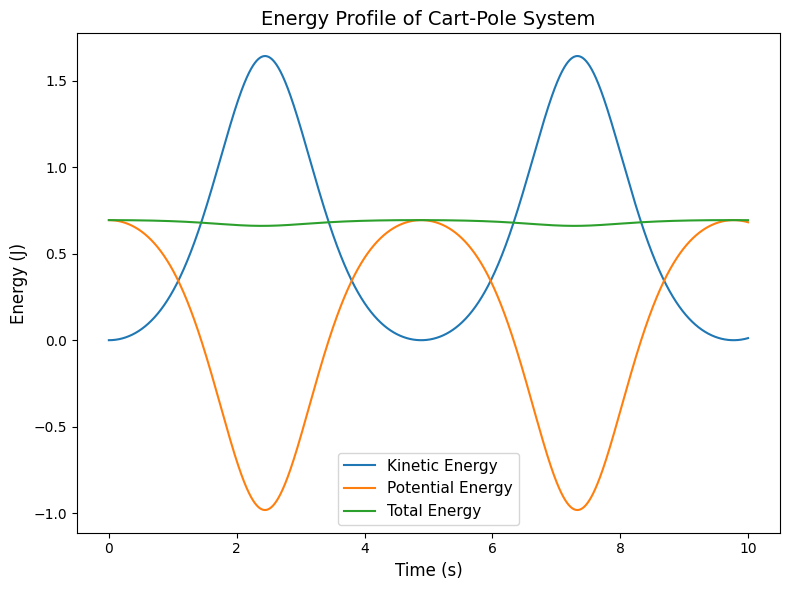

In [9]:
# Write your code: Kinematic, potential, and total energy plot
ke_hist = np.zeros(x_out.shape[1])
pe_hist = np.zeros(x_out.shape[1])
ts = np.arange(0, tf, dt)

for i in range(x_out.shape[1]):
  ke_hist[i] = kinetic_energy(x_out[:, i], params)
  pe_hist[i] = potential_energy(x_out[:, i], params)

#....................................................
plt.figure(figsize=(8, 6))
plt.plot(ts, ke_hist, label='Kinetic Energy')
plt.plot(ts, pe_hist, label='Potential Energy')
plt.plot(ts, ke_hist + pe_hist, label='Total Energy')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Energy (J)', fontsize=12)
plt.title('Energy Profile of Cart-Pole System', fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

## Q.1.(d) [10 pts] Energy profile analysis

Explain the meaning of energy profiles by correlating them with the system's behavior.

Your answer: When the arm gather speed due to droping down motion, it gather the kinetic energy while potential engergy decreases. However, total amount of energy (kinetic + potential energy) is conserved since there is no external forces.

When the pendulum drops down from its initial position at θ = π/4, gravitational potential energy is converted into kinetic energy as it accelerates. The pendulum reaches maximum velocity at the bottom of its swing (θ ≈ 0), where kinetic energy is highest and potential energy is lowest. As it swings back up, kinetic energy converts back to potential energy. The total energy (kinetic + potential) remains approximately constant throughout the motion since there are no external forces or dissipative elements in the system, demonstrating conservation of energy.

# **Q.2 Dynamics of a cart-pole system (Mujoco)**

You will implement the same system using Mujoco simulator, then compare with the one you maded above.

In [10]:
!pip install mujoco

In [11]:
#Import packages for plotting and creating graphics: No need to change
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting: No need to change
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

import mujoco

Installing mediapy:
Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


## Q.2.(a) [15 pts] XML file

The following code is an XML file defining a cart-pole system. Most parts are correct, but the mass and inertia parameters differ from the system implemented above. Please identify those parameters and update them to match the previous system properties.
(The parameters for the cart-pole that you used are: $m_1 = 0.5, m_2 = 0.5, I_2 = 1, c = 0.2$.)

*Feel free to use Google, Gemini, or GPT to understand XML syntax. The official MuJoCo XML documentation can be found at: https://mujoco.readthedocs.io/en/stable/XMLreference.html*

In [12]:
# System definition (xml file)
xml_cart_pole = """
<mujoco model='cartpole'>
  <option timestep='0.005' gravity="0 0 -9.81"/>
  <compiler angle="radian"/>

  <visual>
    <global offwidth="700" offheight="400"/>  # Set the offscreen framebuffer height
  </visual>
  <worldbody>
    <light name="spotlight" mode="fixed" target="cart" pos="0 -1 2"/>

    <camera name='fixed' pos='0 -2.5 0' quat='0.707 0.707 0 0'/>
    <geom name='floor' pos='0 0 -1' size='4 4 4' type='plane' />

    <body name='cart' pos='0 0 0'>
      <joint name='slider' type='slide' pos='0 0 0' axis='1 0 0' range='-1.0 1.0' />
      <geom name='cart' type='box' pos='0 0 0' size='0.25 0.1 0.05' rgba='0.7 0.7 0 1' />
      <inertial pos="0 0 0" quat="1 0 0 0" mass="0.5" diaginertia="0.05 0.03 0.02"/>

      <body name='pole' pos='0 0 0'>
        <joint name='hinge' type='hinge' pos='0 0 0' axis='0 1 0'/>
        <geom name='cpole' type='capsule' fromto='0 0 0 0 0 0.4' size='0.045 0.3' rgba='0 0.7 0.7 1' />
        <inertial pos="0 0 0.2" quat="1 0 0 0" mass="0.5" diaginertia="0.98 0.98 0.001"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name='slide' joint='slider' ctrllimited='true' ctrlrange='-100 100' gear="1"/>
  </actuator>

  <keyframe>
    <key name="hanging_down" qpos="0 0.7854" qvel="0 0" />
  </keyframe>

</mujoco>
"""

In [13]:
# Make model, data, and renderer: No need to change
mj_model = mujoco.MjModel.from_xml_string(xml_cart_pole)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model, width=700, height=400)

# enable joint visualization option: No need to change
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False

duration = 7.0  # (seconds)
framerate = 30  # (Hz)

frames = []
mujoco.mj_resetDataKeyframe(mj_model, mj_data, 0)

while mj_data.time < duration:

  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video
media.show_video(frames, fps=framerate)

## Q.2.(b) [10 pts] Kinetic and Potential Energy

Plot the kinetic, potential, and total energy of the system.
Compare the energy plots with the ones you obtained from your custom simulator.

In [19]:
# plot Kinetic and Potential energy computed from Mujoco
# along with the data you found in your custom simulator
mujoco.mj_resetDataKeyframe(mj_model, mj_data, 0)
mj_model.opt.enableflags |= mujoco.mjtEnableBit.mjENBL_ENERGY
mujoco.mj_step(mj_model, mj_data)

Inertia_Mtx = np.zeros((2,2))
mujoco.mj_fullM(mj_model, Inertia_Mtx, mj_data.qM)
pole_mass = mj_data.crb[2][9]
grav = 9.81

kin_energy_mujoco = []
pot_energy_mujoco = []
kin_energy_mujoco_fn = []
pot_energy_mujoco_fn = []
total_energy_mujoco = []
time_mujoco = []

while mj_data.time < tf:
  mj_data.ctrl = 0;
  # Write your code to compute kinetic, position, and total energy
  x = mj_data.qpos[0]
  th = mj_data.qpos[1]
  xdot = mj_data.qvel[0]
  thdot = mj_data.qvel[1]
  q_state = np.array([x, th, xdot, thdot])

  ke_manual = kinetic_energy(q_state, params)
  pe_manual = potential_energy(q_state, params)

  ke_mujoco = mj_data.energy[0]
  pe_mujoco = mj_data.energy[1]

  kin_energy_mujoco.append(ke_mujoco)
  pot_energy_mujoco.append(pe_mujoco)
  kin_energy_mujoco_fn.append(ke_mujoco)
  pot_energy_mujoco_fn.append(pe_mujoco)
  total_energy_mujoco.append(ke_mujoco + pe_mujoco)
  time_mujoco.append(mj_data.time)

  mujoco.mj_step(mj_model, mj_data)

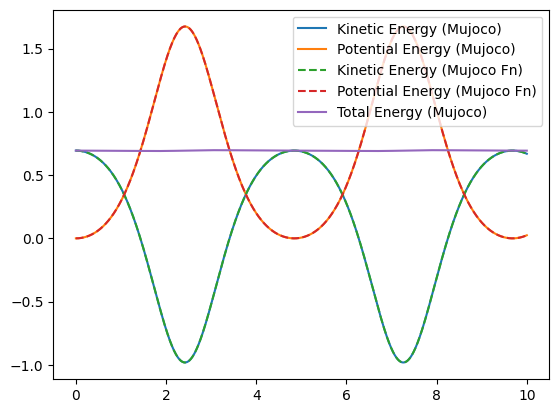

In [20]:
# Plot: No need to change
plt.plot(time_mujoco, kin_energy_mujoco, label='Kinetic Energy (Mujoco)')
plt.plot(time_mujoco, pot_energy_mujoco, label='Potential Energy (Mujoco)')
plt.plot(time_mujoco, kin_energy_mujoco_fn, label='Kinetic Energy (Mujoco Fn)', linestyle="--")
plt.plot(time_mujoco, pot_energy_mujoco_fn, label='Potential Energy (Mujoco Fn)', linestyle="--")
plt.plot(time_mujoco, total_energy_mujoco, label='Total Energy (Mujoco)')

# plt.plot(ts, ke_hist, linestyle='--', label='Kinetic Energy')
# plt.plot(ts, pe_hist, linestyle='--', label='Potential Energy')
# plt.plot(ts, pe_hist+ke_hist, linestyle='--', label='Total Energy')

plt.legend()
plt.show()

## Q.2.(c) [10 pts] Trajectory comparison

Plot x position of cart and joint angle of pendulum, and compare them with the ones computed from your simulator. Then, analyze the results.

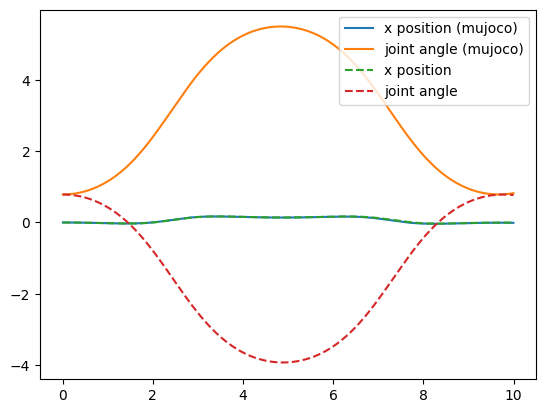

In [16]:
mujoco.mj_resetDataKeyframe(mj_model, mj_data, 0)
mujoco.mj_step(mj_model, mj_data)

x_pos_mujoco = []
joint_angle_mujoco = []
time_mujoco = []

while mj_data.time < tf:
  mj_data.ctrl = 0
  # Write your code here
  x_pos_mujoco.append(mj_data.qpos[0])
  joint_angle_mujoco.append(mj_data.qpos[1])
  #.........................................................
  time_mujoco.append(mj_data.time)
  mujoco.mj_step(mj_model, mj_data)

plt.plot(time_mujoco, x_pos_mujoco, label='x position (mujoco)' )
plt.plot(time_mujoco, joint_angle_mujoco, label='joint angle (mujoco)' )

plt.plot(ts, x_out[0,:], linestyle='--', label='x position' )
plt.plot(ts, x_out[1,:], linestyle='--', label='joint angle' )

plt.legend()
plt.show()

## Q.2. (d) [10 pts] Do you get the same results? If not, please explain why:

In MuJoCo, the axis of the pendulum is aligned with the $y$-axis, which points into the screen (positive $x$ is to the right, and positive $z$ is vertically upward). Therefore, the joint angles may appear mirrored. Note that the energy is not affected by this sign difference, as it depends on the square of the velocities.


The results show good agreement between the two simulators, though with notable differences in joint angle signs due to coordinate system conventions. MuJoCo's pendulum axis is aligned with the y-axis pointing into the screen, while our custom simulator uses rotation in the x-y plane, causing the joint angles to appear mirrored. MuJoCo shows the angle increasing to about 6 rad while the custom simulator shows it decreasing to about -4 rad for the same physical motion. However, both simulators correctly conserve energy (as shown in part b) since energy depends on the square of velocities and cosine of angles, which are unaffected by sign differences. The cart positions match closely in both cases, confirming that the underlying physics is correctly modeled despite the coordinate convention differences.